In [2]:
import brainpy as bp
import brainpy.math as bm
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.linalg import eig
#gridspec
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import sys
sys.path.append('..')
from cann import CANN1D

/home/zilong/anaconda3/envs/hippocampalsequence/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### set the hyper-parameters and functions

In [2]:
N = 128 #network size, i.e., number of place cells
M = 10 #truncate the number of eigenvalues, i.e., Fourier modes? 
epsilon = 1 #pertub strength, relating to the adaptation strength
offset = 10 #offset, relating to the distance between U bump and V bump

In [3]:
#generate a pertubation matrix with offset-th diagonal values equal to epsilon, other values are zero
def get_pertub_mat(N, epsilon, offset):
    '''
    get a circular matrix with offset-th diagonal values equal to epsilon, other values are zero
    N: int, the size of the matrix
    epsilon: float, the value of the offset-th diagonal
    offset: int, the offset of the diagonal
    '''
    pertub_mat = np.zeros((N, N))
    for i in range(N):
        if i+offset < N:
            pertub_mat[i, i+offset] = epsilon
        else:
            pertub_mat[i, i+offset-N] = epsilon
    return pertub_mat

def get_pertub_mat_4_visualization(N, epsilon, offset, width=5):
    '''
    get a circular matrix with offset-th diagonal values equal to epsilon, other values are zero
    N: int, the size of the matrix
    epsilon: float, the value of the offset-th diagonal
    offset: int, the offset of the diagonal
    '''
    pertub_mat = np.zeros((N, N))
    for i in range(N):
        if i+offset < N:
            pertub_mat[i, i+offset-width:i+offset+width] = epsilon
        else:
            pertub_mat[i, i+offset-width-N:i+offset+width-N] = epsilon
    return pertub_mat


### plot perturbation matrix

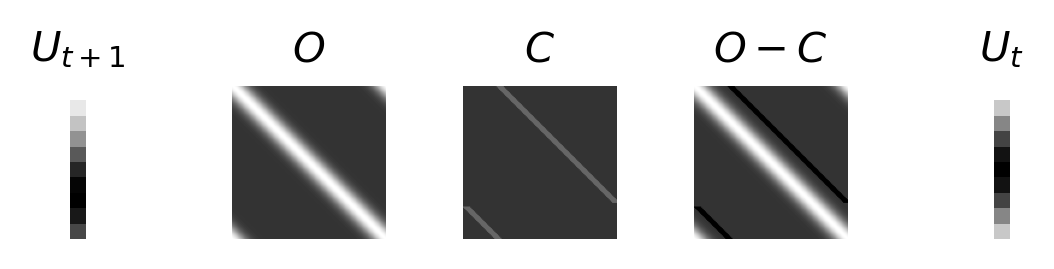

In [40]:
#get the connection matrix from the CANN, i.e., the generator
replay_cann = CANN1D(tau=1., tau_v=48., num=N, mbar=1.5)

weight_mat = np.zeros((N, N))
for i in range(N):
    weight_vec = replay_cann.make_conn_i(i)
    weight_mat[i,:] = weight_vec

offset = 30

fig = plt.figure(figsize=(4, 1), dpi=300)
labelsize = 10
ticksize = 8
#gridspec.GridSpec(2, 2)
gs = gridspec.GridSpec(1, 5)

#generate a M vector with Gaussian bump using numpy center at N/2
M=10
x = np.arange(M)
y = np.exp(-((x-M/1.5)**2)/(2*3**2))
y = y/np.sum(y)
y = 1-y
#plot the vector in the vertical way
ax0 = fig.add_subplot(gs[0, 0])
ax0.imshow(y[:, np.newaxis], cmap='gray', vmin=np.min(y), vmax=np.max(y))
ax0.set_yticks([]); ax0.set_xticks([])
ax0.set_title(r"$U_{t+1}$", fontsize=labelsize)

#plot the connection matrix
ax1 = fig.add_subplot(gs[0, 1])
minval = np.min(weight_mat)
maxval = np.max(weight_mat)
ax1.imshow(weight_mat, cmap='gray', vmin=minval-epsilon, vmax=maxval)
ax1.set_yticks([]); ax1.set_xticks([])
ax1.set_title(r"$O$", fontsize=labelsize)

#plot the pertubation matrix 1
ax2 = fig.add_subplot(gs[0, 2])
pertub_mat_1 = get_pertub_mat_4_visualization(N, epsilon, offset, width=3)
ax2.imshow(pertub_mat_1, cmap='gray', vmin=minval-epsilon, vmax=maxval)
ax2.set_yticks([]); ax2.set_xticks([])
ax2.set_title(r"$C$", fontsize=labelsize)

#subtract the pertubation matrix 1 from the connection matrix and plot
ax3 = fig.add_subplot(gs[0, 3])
ax3.imshow(weight_mat-pertub_mat_1, cmap='gray', vmin=minval-epsilon, vmax=maxval)
ax3.set_yticks([]); ax3.set_xticks([])
ax3.set_title(r"$O-C$", fontsize=labelsize)

#generate a M vector with Gaussian bump using numpy center at N/2
x = np.arange(M)
y = np.exp(-((x-M/2)**2)/(2*3**2))
y = y/np.sum(y)
y = 1-y
#plot the vector in the vertical way
ax4 = fig.add_subplot(gs[0, 4])
ax4.imshow(y[:, np.newaxis], cmap='gray', vmin=np.min(y), vmax=np.max(y))
ax4.set_yticks([]); ax0.set_xticks([])
ax4.set_title(r"$U_{t}$", fontsize=labelsize)

#set axis off
for ax in [ax0, ax1, ax2, ax3, ax4]:
    ax.axis('off')

plt.tight_layout()

#save the figure
plt.savefig('./Fig7_v2_pertubation_%d.pdf'%offset, dpi=300)

## generating a trainsition matrix and simulating sampling

In [1]:
import jax
import brainpy.math as bm
import matplotlib.pyplot as plt
from scipy.linalg import eig
import numpy as np
from tqdm import tqdm

/home/zilong/anaconda3/envs/anticipative_track/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
z_range = np.linspace(0, 1, 10)
bm.asarray([z_range, z_range]).shape

x = bm.linspace(0, 1, 50+1)[0:-1]
x1, x2 = bm.meshgrid(x, x)
value = bm.stack([x1.flatten(), x2.flatten()]).T
value

Array(value=Array([[0.        , 0.        ],
                   [0.02      , 0.        ],
                   [0.04      , 0.        ],
                   ...,
                   [0.94      , 0.97999996],
                   [0.96      , 0.97999996],
                   [0.97999996, 0.97999996]]),
      dtype=float32)

In [4]:
def dist(d, z_range):
    v_size = bm.asarray([z_range, z_range])
    return bm.where(d > v_size / 2, v_size - d, d)

def make_conn(z_min=-bm.pi, z_max=bm.pi, length=100, J0=4., a=0.5):
    x = bm.linspace(z_min, z_max, length+1)[0:-1]
    x1, x2 = bm.meshgrid(x, x)
    value = bm.stack([x1.flatten(), x2.flatten()]).T
    z_range = z_max - z_min

    @jax.vmap
    def get_J(v):
        d = dist(bm.abs(v - value), z_range)
        d = bm.linalg.norm(d, axis=1)
        # d = d.reshape((self.length, self.length))
        Jxx = J0 * bm.exp(-0.5 * bm.square(d / a)) / (bm.sqrt(2 * bm.pi) * a)
        return Jxx
    
    return get_J(value)

#simulating Brownian motion on the 2D sheet with raw connection matrix
def sampling_simulation(W, dim, steps=1000, noise_level=0.01, visualization=False):
    #generating a 2D Gaussian bump at the center of the 2D sheet
    U0 = np.zeros((dim, dim))
    x, y = np.meshgrid(np.arange(dim), np.arange(dim))
    x0, y0 = dim//2, dim//2
    U0 = np.exp(-((x-x0)**2+(y-y0)**2)/(2*1**2))
    r1 = np.square(U0)
    r2 = 1+0.1*np.sum(r1)
    U0 = r1/r2
    # U0 = U0/np.sum(U0)
    # plt.imshow(U0)
        
    #simulating the dynamics for steps by multiplying the connection matrix with the initial condition
    U = U0
    trajectory = []
    for i in tqdm(range(steps)):
        noise = np.random.normal(0, noise_level, (dim, dim))
        U = U + noise
        
        U = np.dot(W, U.flatten())
        r1 = np.square(U)
        r2 = 1+0.1*np.sum(r1)
        U = r1/r2
        U = U.reshape((dim, dim))
        
        #get the index of peak of U
        peak_idx = np.unravel_index(np.argmax(U, axis=None), U.shape)
        trajectory.append(peak_idx)
        
        if visualization is True:
            if i%100==0:
                plt.imshow(U)
                plt.show()
        
    return np.array(trajectory)


(2500, 2500)

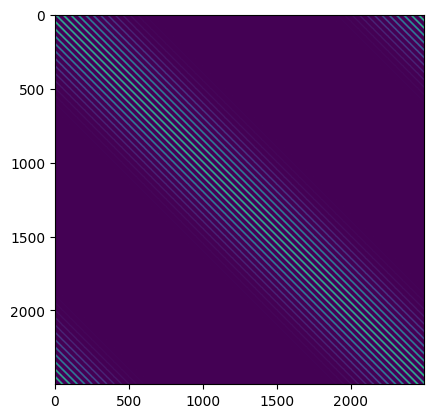

In [172]:
#visualize Jxx
dim = 50
Jxx = make_conn(z_min=-bm.pi, z_max=bm.pi, length=50, J0=4., a=0.5)
#set diagonal to zero
Jxx = Jxx - bm.diag(bm.diag(Jxx))
plt.imshow(bm.as_numpy(Jxx))
Jxx.shape

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:07<00:00, 127.44it/s]


[Text(0, 0, '0'), Text(0, 50, '1')]

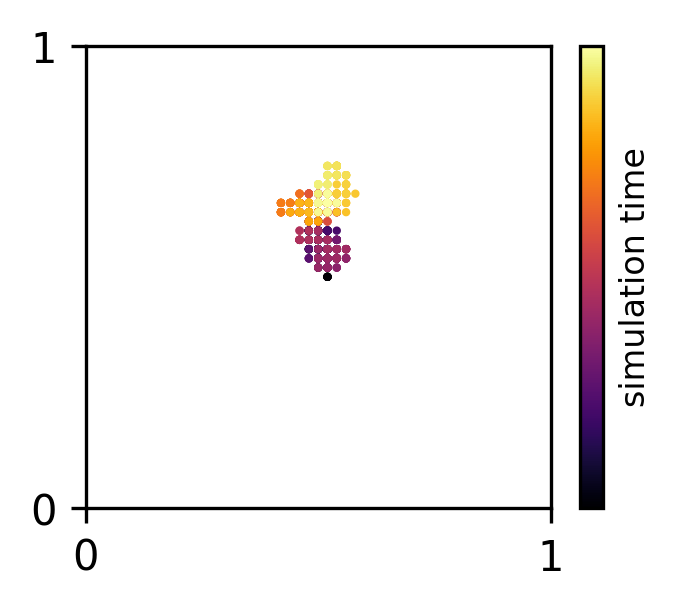

In [18]:
#plot the trajectory
#set random seed
# np.random.seed(0)
# bm.random.seed(0)
dim = 50
W = make_conn(z_min=0, z_max=1, length=dim, J0=4., a=0.1)
#minus with a identity matrix
W = W-bm.eye(dim*dim)
trajectory = sampling_simulation(W, dim, steps=1000, noise_level=0.02, visualization=False)

##############################################
fig, ax = plt.subplots(1, 1, figsize=(2.5,2), dpi=300)
# ax.plot(trajectory[:,0], trajectory[:,1], color='grey', linewidth=0.5, alpha=0.5)
#plot scatter with gradually changing color
scatters = ax.scatter(trajectory[:,0], trajectory[:,1], c=np.arange(trajectory.shape[0]), cmap='inferno', s=1)

#remove the ticks on colorbar and add "simulation time" as colorbar label
cb = plt.colorbar(scatters)
cb.set_ticks([])
cb.set_label('simulation time', fontsize=8)

    
ax.set_xlim([0, dim])
ax.set_ylim([0, dim])
#set xticks to 0-1
ax.set_xticks([0, dim])
ax.set_yticks([0, dim])
ax.set_xticklabels([0, 1])
ax.set_yticklabels([0, 1])

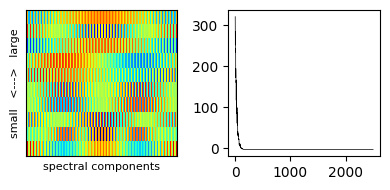

In [76]:
#eigen decomposition of the connection matrix and plot the first M eigenvectors
M = 10
#eigendecomposition of the connection matrix
evals, evecs_l, evecs_r = eig(Jxx, left=True, right=True) 

fig, axs = plt.subplots(1, 2, figsize=(4,2))
#imshow with the image as a squared one
axs[0].imshow(np.real(evecs_l[:,1:M+1].T), cmap='jet', interpolation='none', aspect='auto')
axs[0].set_yticks([]); axs[0].set_xticks([])
#set ylabel as large <---> small
axs[0].set_ylabel('small   <--->   large', fontsize=8)
axs[0].set_xlabel('spectral components', fontsize=8)

##plot the distribution of eigenvalues
axs[1].plot(np.real(evals), color='black', linewidth=0.5)

plt.tight_layout()

100%|██████████| 1000/1000 [00:04<00:00, 213.30it/s]


[Text(0, 0, '0'), Text(0, 50, '1')]

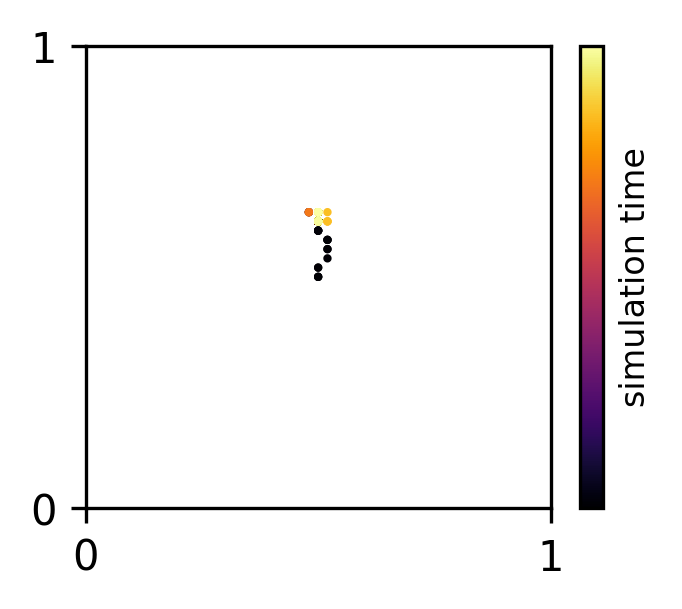

In [158]:
#downscale the frist M eigenvalues
evals, evecs_l, evecs_r = eig(W, left=True, right=True) 

M=20
scaled_evals = np.zeros_like(evals)
scaled_evals[0:M] = evals[0:M]*0.5
scaled_evals[M:] = evals[M:]

scale_W = np.dot(evecs_l, np.dot(np.diag(scaled_evals), evecs_l.T))
scale_W = np.abs(scale_W)

scale_trajectory = sampling_simulation(scale_W, dim, steps=1000, noise_level=0.01, visualization=False)

##############################################
fig, ax = plt.subplots(1, 1, figsize=(2.5,2), dpi=300)
# ax.plot(trajectory[:,0], trajectory[:,1], color='grey', linewidth=0.5, alpha=0.5)
#plot scatter with gradually changing color
scatters = ax.scatter(scale_trajectory[:,0], scale_trajectory[:,1], c=np.arange(scale_trajectory.shape[0]), cmap='inferno', s=1)

#remove the ticks on colorbar and add "simulation time" as colorbar label
cb = plt.colorbar(scatters)
cb.set_ticks([])
cb.set_label('simulation time', fontsize=8)

    
ax.set_xlim([0, dim])
ax.set_ylim([0, dim])
#set xticks to 0-1
ax.set_xticks([0, dim])
ax.set_yticks([0, dim])
ax.set_xticklabels([0, 1])
ax.set_yticklabels([0, 1])

100%|██████████| 1000/1000 [00:04<00:00, 215.74it/s]


[Text(0, 0, '0'), Text(0, 50, '1')]

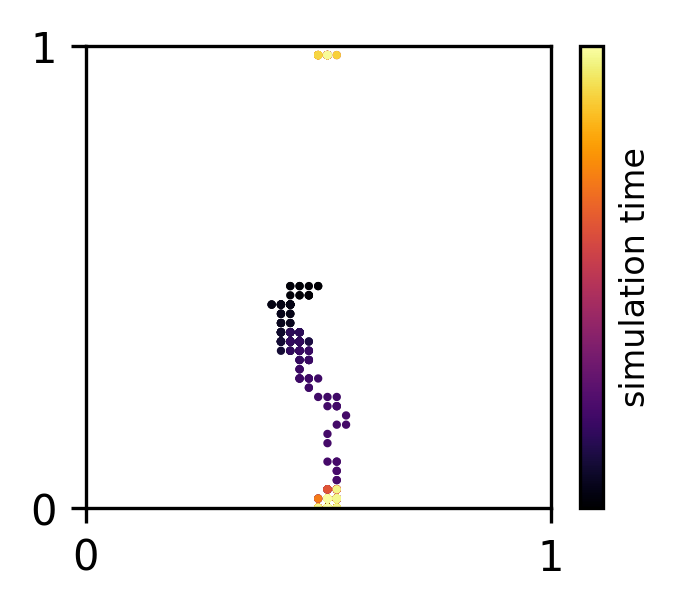

In [23]:
M = 20
#upscale the frist M eigenvalues
dim=50
W = make_conn(z_min=0, z_max=1, length=dim, J0=4., a=0.1)
#W = W-bm.eye(dim*dim)
evals, evecs_l, evecs_r = eig(W, left=True, right=True) 

#upscale the first M odd eigenvalues, and downscale the first M even eigenvalues
scaled_evals = np.zeros_like(evals)
for i in range(0, M, 2):
    scaled_evals[i] = evals[i]*1.2
    scaled_evals[i+1] = evals[i+1]*0.8

scaled_evals[M:] = evals[M:]

scale_W = np.dot(evecs_l, np.dot(np.diag(scaled_evals), evecs_l.T))
scale_W = np.abs(scale_W)

scale_trajectory = sampling_simulation(scale_W, dim, steps=1000, noise_level=0.02, visualization=False)

##############################################
fig, ax = plt.subplots(1, 1, figsize=(2.5,2), dpi=300)
# ax.plot(trajectory[:,0], trajectory[:,1], color='grey', linewidth=0.5, alpha=0.5)
#plot scatter with gradually changing color
scatters = ax.scatter(scale_trajectory[:,0], scale_trajectory[:,1], c=np.arange(scale_trajectory.shape[0]), cmap='inferno', s=1)

#remove the ticks on colorbar and add "simulation time" as colorbar label
cb = plt.colorbar(scatters)
cb.set_ticks([])
cb.set_label('simulation time', fontsize=8)

    
ax.set_xlim([0, dim])
ax.set_ylim([0, dim])
#set xticks to 0-1
ax.set_xticks([0, dim])
ax.set_yticks([0, dim])
ax.set_xticklabels([0, 1])
ax.set_yticklabels([0, 1])

100%|██████████| 1000/1000 [00:04<00:00, 216.48it/s]


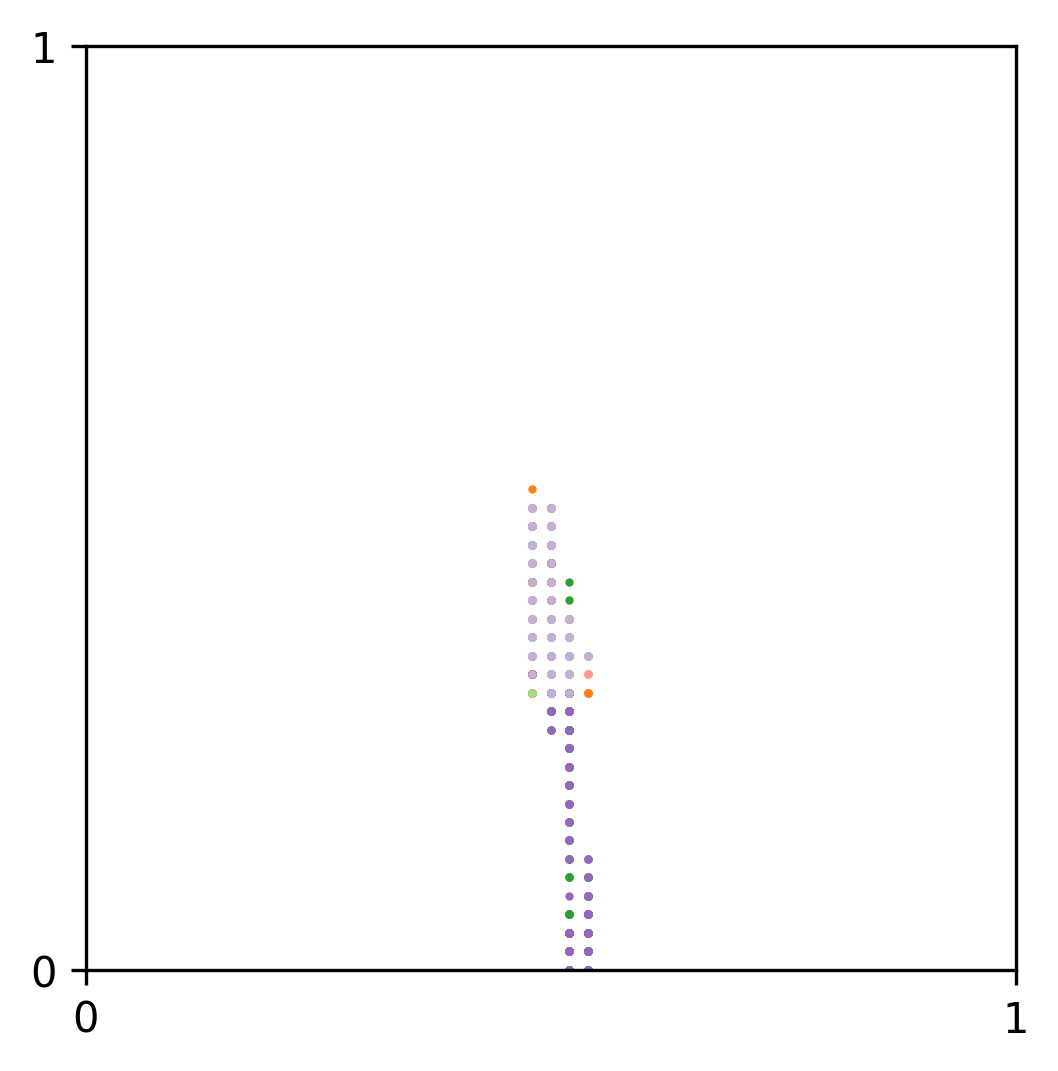

In [7]:
#simulate 10 trajectorys
fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=300)
M=10
#chooose tab20 color map
tab20 = plt.get_cmap('tab20')
for i in range(10):
    color_i = tab20(i)
    dim=50
    W = make_conn(z_min=0, z_max=1, length=dim, J0=4., a=0.1)
    W = W-bm.eye(dim*dim)
    evals, evecs_l, evecs_r = eig(W, left=True, right=True) 
    #upscale the first M odd eigenvalues, and downscale the first M even eigenvalues
    scaled_evals = np.zeros_like(evals)
    for i in range(0, M, 2):
        scaled_evals[i] = evals[i]*1.1
        scaled_evals[i+1] = evals[i+1]*0.9
    scaled_evals[M:] = evals[M:]
    scale_W = np.dot(evecs_l, np.dot(np.diag(scaled_evals), evecs_l.T))
    scale_W = np.abs(scale_W)
    scale_trajectory = sampling_simulation(scale_W, dim, steps=1000, noise_level=0.01, visualization=False)
    
    # ax.plot(scale_trajectory[:,0], scale_trajectory[:,1], color='grey', linewidth=0.5, alpha=0.5)
    scatters = ax.scatter(scale_trajectory[:,0], scale_trajectory[:,1], color = color_i, s=1)

    # #remove the ticks on colorbar and add "simulation time" as colorbar label
    # cb = plt.colorbar(scatters)
    # cb.set_ticks([])
    # cb.set_label('simulation time', fontsize=8)
        
    ax.set_xlim([0, dim])
    ax.set_ylim([0, dim])
    #set xticks to 0-1
    ax.set_xticks([0, dim])
    ax.set_yticks([0, dim])
    ax.set_xticklabels([0, 1])
    ax.set_yticklabels([0, 1])

## simulating 1D CAN


In [191]:
np.arange(1, 10, 1)

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

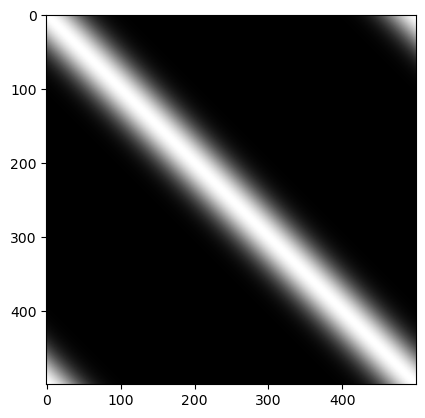

In [226]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from cann import CANN1D
from tqdm import tqdm
from scipy.linalg import eig

#get the connection matrix from the CANN, i.e., the generator
def get_connection(dim=500):
    replay_cann = CANN1D(tau=1., tau_v=48., num=dim, mbar=1.5)

    weight_mat = np.zeros((dim, dim))
    for i in range(dim):
        weight_vec = replay_cann.make_conn_i(i)
        weight_mat[i,:] = weight_vec
    return weight_mat

def oscillatory_scalling(weight_mat, M=20, upscale_factor=1.5, downscale_factor=0.5):
    '''
    scale the first M odd eigenvalues by upscale_factor, and scale the first M even eigenvalues by downscale_factor
    weight_mat: np.array, the connection matrix
    M: int, the number of eigenvalues to be scaled
    upscale_factor: float, the factor to scale the odd eigenvalues
    downscale_factor: float, the factor to scale the even eigenvalues
    '''
    evals, evecs_l, evecs_r = eig(weight_mat, left=True, right=True) 
    scaled_evals = np.zeros_like(evals)
    for i in range(1, M, 4):
        scaled_evals[i] = evals[i]*upscale_factor
        scaled_evals[i+1] = evals[i+1]*upscale_factor
        scaled_evals[i+2] = evals[i+2]*downscale_factor
        scaled_evals[i+3] = evals[i+3]*downscale_factor

    scaled_evals[0] = evals[0]
    scaled_evals[M:] = evals[M:]

    scale_weight_mat = np.dot(evecs_l, np.dot(np.diag(scaled_evals), evecs_l.T))
    scale_weight_mat = np.real(scale_weight_mat)
    
    return scale_weight_mat

def quadratic_scalling(weight_mat, M=20, up_value=1.5, down_value=0.5):
    '''
    scale the first M eigenvalues by a quadratic function
    weight_mat: np.array, the connection matrix
    M: int, the number of eigenvalues to be scaled
    upscale_factor: float, the factor to scale the odd eigenvalues
    downscale_factor: float, the factor to scale the even eigenvalues
    '''
    #get the scaling factor at each point
    x = np.arange(0, M, 1)
    #the curve is y = a*x^2+b cross (0, down_value) and (M, up_value)
    a = (up_value-down_value)/M**2
    b = down_value
    scalling_factor = a*x**2+b

    plt.plot(x, scalling_factor)
    
    evals, evecs_l, evecs_r = eig(weight_mat, left=True, right=True) 
    scaled_evals = np.zeros_like(evals) 
    scaled_evals[1:M+1] = evals[1:M+1]*scalling_factor
    scaled_evals[M+1:] = evals[M+1:]
    #reset the first eigenvalue
    scaled_evals[0] = evals[0]
    
    scale_weight_mat = np.dot(evecs_l, np.dot(np.diag(scaled_evals), evecs_l.T))     
    
    return scale_weight_mat
    

def sampling_simulation(weight_mat, dim, steps=1000, noise_level=0.01, visualization=False):
    #generating a 2D Gaussian bump at the center of the 2D sheet
    U0 = np.zeros(dim)
    x0 = dim//2
    x = np.arange(dim)
    U0 = np.exp(-((x-x0)**2)/(2*3**2))
    r1 = np.square(U0)
    r2 = 1+0.1*np.sum(r1)
    U0 = r1/r2

    #simulating the dynamics for steps by multiplying the connection matrix with the initial condition
    U = U0
    trajectory = []
    sampled_U = []
    for i in tqdm(range(steps)):
        noise = np.random.normal(0, noise_level, dim)
        U = U + noise
        
        U = np.dot(weight_mat, U)
        r1 = np.square(U)
        r2 = 1+0.1*np.sum(r1)
        U = r1/r2

        #get the index of peak of U
        peak_idx = np.argmax(U)
        trajectory.append(peak_idx)
        
        gap = int(steps/10)
        if i%gap==0:
            sampled_U.append(U)
            
    if visualization is True:
        fig, axs = plt.subplots(10, 1, figsize=(4,10))
        for i in range(len(sampled_U)):
            axs[i].plot(sampled_U[i], label='t=%d'%i)
            axs[i].set_xticks([])
            axs[i].set_yticks([])
            
    return np.array(trajectory)

weight_mat = get_connection(dim=500)
plt.imshow(weight_mat, cmap='gray')

100%|██████████| 200/200 [00:00<00:00, 31325.32it/s]


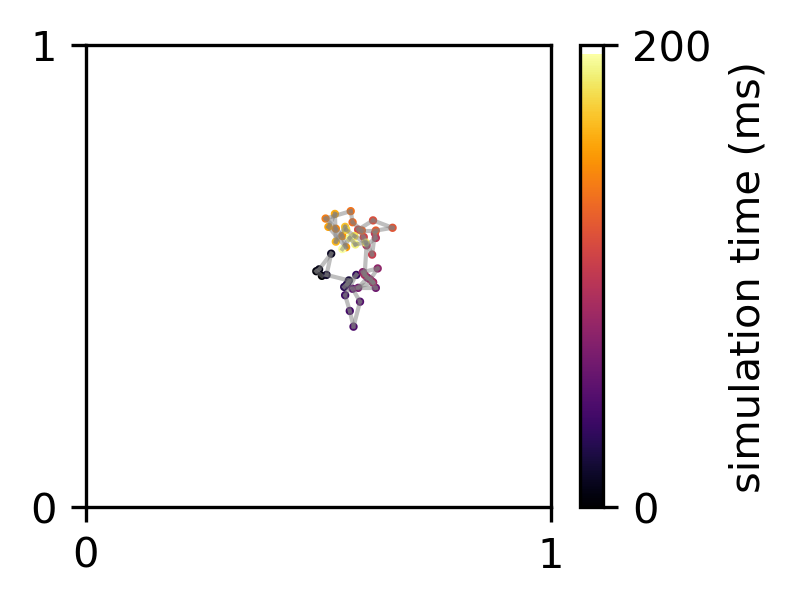

In [186]:
np.random.seed(11)
weight_mat = get_connection(dim=500)

steps = 200
downsamples = 50
traj_x = sampling_simulation(weight_mat, dim, steps=steps, noise_level=0.1, visualization=False)
traj_y = sampling_simulation(weight_mat, dim, steps=steps, noise_level=0.1, visualization=False)

#downsample the trajectory to 1/100
traj_x = traj_x[::steps//downsamples]
traj_y = traj_y[::steps//downsamples]
#plot trajectory
fig, ax = plt.subplots(1, 1, figsize=(2.5,2), dpi=300)
for i in range(1,len(traj_x)):
    #if the distance between two points is smaller than dim//2, plot the link between two points
    if np.abs(traj_x[i]-traj_x[i-1])<dim//2 and np.abs(traj_y[i]-traj_y[i-1])<dim//2:
        ax.plot([traj_x[i-1], traj_x[i]], [traj_y[i-1], traj_y[i]], color='grey', linewidth=1.0, alpha=0.5)
scatters = ax.scatter(traj_x, traj_y, c=np.arange(len(traj_x)), cmap='inferno', s=1)
ax.set_xlim([0, dim])
ax.set_ylim([0, dim])
ax.set_xticks([0, dim])
ax.set_yticks([0, dim])
ax.set_xticklabels([0, 1])
ax.set_yticklabels([0, 1])

#colorbar
cb = plt.colorbar(scatters)
cb.set_ticks([0, downsamples])
cb.set_ticklabels([0, steps])
cb.set_label('simulation time (ms)', fontsize=10)

plt.show()


100%|██████████| 200/200 [00:00<00:00, 3403.83it/s]


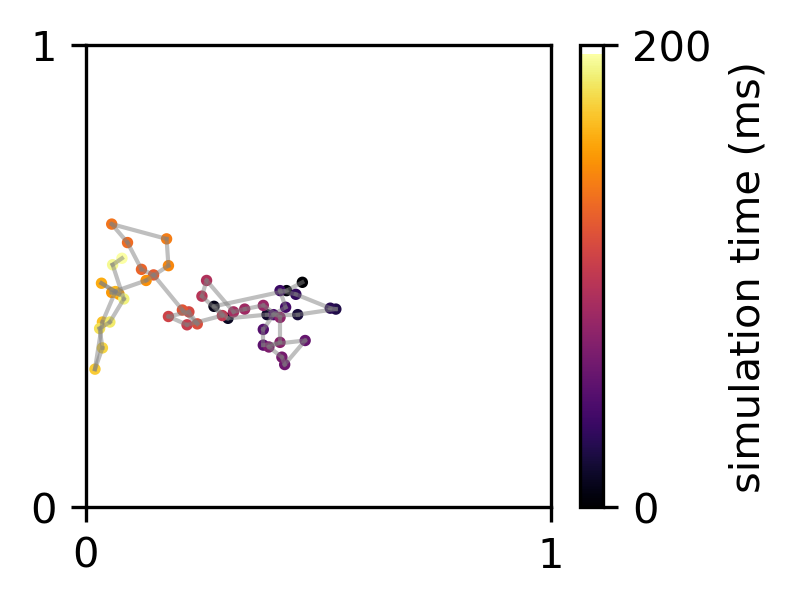

In [247]:
np.random.seed(11)
weight_mat = get_connection(dim=500)
scale_weight_mat = oscillatory_scalling(weight_mat, M=20, downscale_factor=0.5, upscale_factor=1.5)
steps = 200
downsamples = 50
traj_x = sampling_simulation(scale_weight_mat, dim, steps=steps, noise_level=0.1, visualization=False)
traj_y = sampling_simulation(scale_weight_mat, dim, steps=steps, noise_level=0.1, visualization=False)
#downsample the trajectory
traj_x = traj_x[::steps//downsamples]
traj_y = traj_y[::steps//downsamples]
#plot trajectory
fig, ax = plt.subplots(1, 1, figsize=(2.5,2), dpi=300)
for i in range(1,len(traj_x)):
    #if the distance between two points is smaller than dim//2, plot the link between two points
    if np.abs(traj_x[i]-traj_x[i-1])<dim/1.1 and np.abs(traj_y[i]-traj_y[i-1])<dim/1.1:
        ax.plot([traj_x[i-1], traj_x[i]], [traj_y[i-1], traj_y[i]], color='grey', linewidth=1, alpha=0.5)
scatters = ax.scatter(traj_x, traj_y, c=np.arange(len(traj_x)), cmap='inferno', s=3)
ax.set_xlim([0, dim])
ax.set_ylim([0, dim])
ax.set_xticks([0, dim])
ax.set_yticks([0, dim])
ax.set_xticklabels([0, 1])
ax.set_yticklabels([0, 1])

#colorbar
cb = plt.colorbar(scatters)
cb.set_ticks([0, downsamples])
cb.set_ticklabels([0, steps])
cb.set_label('simulation time (ms)', fontsize=10)

plt.savefig('./Fig7_v2_oscillatory_scalling_single.pdf', dpi=300)


100%|██████████| 200/200 [00:00<00:00, 10966.79it/s]


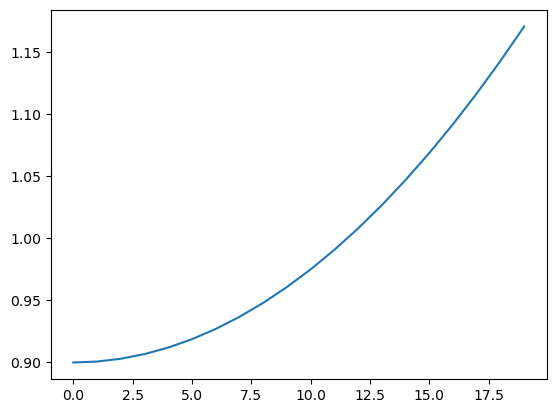

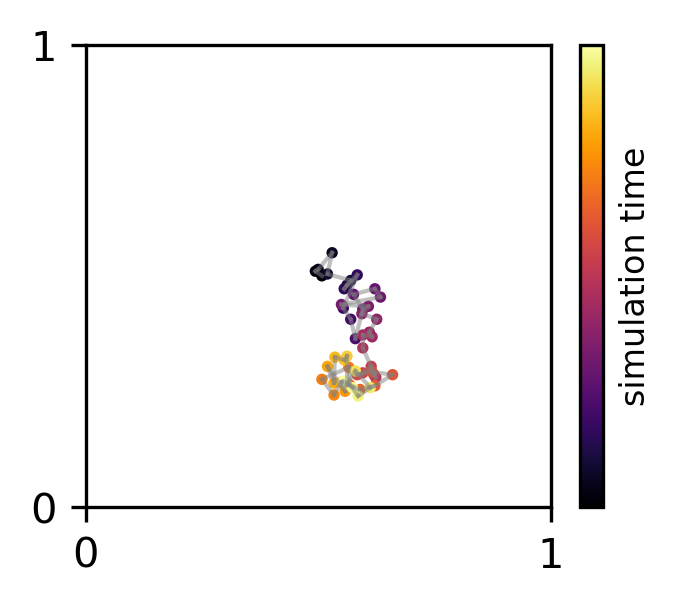

In [231]:
np.random.seed(11)
weight_mat = get_connection(dim=500)
scale_weight_mat = quadratic_scalling(weight_mat, M=20, down_value=0.9, up_value=1.2)
steps = 200
downsamples = 50
traj_x = sampling_simulation(scale_weight_mat, dim, steps=steps, noise_level=0.1, visualization=False)
traj_y = sampling_simulation(scale_weight_mat, dim, steps=steps, noise_level=0.1, visualization=False)
#downsample the trajectory
traj_x = traj_x[::steps//downsamples]
traj_y = traj_y[::steps//downsamples]
#plot trajectory
fig, ax = plt.subplots(1, 1, figsize=(2.5,2), dpi=300)
for i in range(1,len(traj_x)):
    #if the distance between two points is smaller than dim//2, plot the link between two points
    if np.abs(traj_x[i]-traj_x[i-1])<dim/1.1 and np.abs(traj_y[i]-traj_y[i-1])<dim/1.1:
        ax.plot([traj_x[i-1], traj_x[i]], [traj_y[i-1], traj_y[i]], color='grey', linewidth=1, alpha=0.5)
scatters = ax.scatter(traj_x, traj_y, c=np.arange(len(traj_x)), cmap='inferno', s=3)
ax.set_xlim([0, dim])
ax.set_ylim([0, dim])
ax.set_xticks([0, dim])
ax.set_yticks([0, dim])
ax.set_xticklabels([0, 1])
ax.set_yticklabels([0, 1])

#colorbar
cb = plt.colorbar(scatters)
cb.set_ticks([])
cb.set_label('simulation time', fontsize=8)

plt.show()
